In [1]:
import json

import matplotlib.pyplot as plt

from muutils.zanj import ZANJ
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.training.maze_dataset_configs import MAZE_DATASET_CONFIGS

print(MAZE_DATASET_CONFIGS.keys())

dict_keys(['test-g3-n5-a_dfs-h48692'])


In [2]:
def plot_dataset_mazes(ds: MazeDataset, count: int|None = None):
	count = count or len(ds)
	fig, axes = plt.subplots(1, count, figsize=(15, 5))
	for i in range(count):
		axes[i].imshow(ds[i].as_pixels())
		# remove ticks
		axes[i].set_xticks([])
		axes[i].set_yticks([])


In [3]:
zanj: ZANJ = ZANJ(external_list_threshold=8)
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test",
	grid_n=3,
	n_mazes=32,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
)

In [4]:
dataset: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
    save_local=True,
	local_base_path="../data/",
	verbose=True,
	zanj=zanj,
	gen_parallel=False, # parallel generation has overhead, not worth it unless you're doing a lot of mazes
)

generating & solving mazes: 100%|██████████| 32/32 [00:00<00:00, 1142.86maze/s]


In [5]:
dataset_cpy: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=True,
	do_generate=False,
	local_base_path="../data/",
	verbose=True,
	zanj=zanj,
)


In [6]:
assert dataset.cfg == dataset_cpy.cfg
print(len(dataset), len(dataset_cpy))
print(dataset_cpy[0])
assert all(x == y for x,y in zip(dataset, dataset_cpy))

32 32
SolvedMaze(connection_list=array([[[False, False,  True],
        [ True, False, False],
        [False, False, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]]]), generation_meta=None, lattice_dim=2, start_pos=array([1, 1]), end_pos=array([2, 0]), solution=array([[1, 1],
       [1, 0],
       [2, 0]]))


In [7]:
dataset_filtered: MazeDataset = dataset.filter_by.path_length(min_length=3)

print(f"{len(dataset) = }")
print(f"{len(dataset_filtered) = }")

len(dataset.mazes) = 32
len(dataset_filtered.mazes) = 25


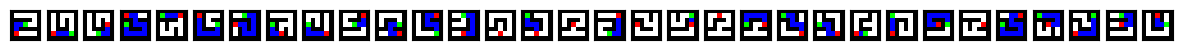

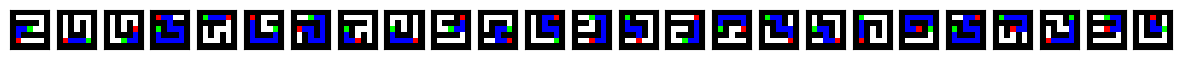

In [8]:
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered)


In [9]:
print(json.dumps(dataset_filtered.cfg.serialize()["applied_filters"], indent=2))
print(f"{MazeDataset._FILTER_NAMESPACE = }")

[
  {
    "name": "path_length",
    "kwargs": {
      "min_length": 3
    }
  }
]
MazeDataset._FILTER_NAMESPACE = <class 'maze_transformer.training.maze_dataset.MazeDatasetFilters'>


In [10]:
dataset_filtered_from_scratch: MazeDataset = MazeDataset.from_config(
	dataset_filtered.cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=False,
	local_base_path="../data/",
	verbose=True,
	zanj=zanj,
	gen_parallel=False, # parallel generation has overhead, not worth it unless you're doing a lot of mazes
)

generating & solving mazes: 100%|██████████| 25/25 [00:00<00:00, 1041.86maze/s]


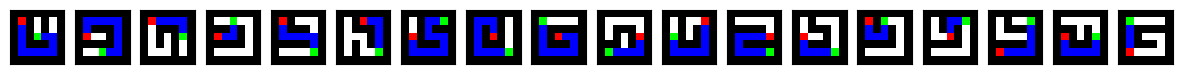

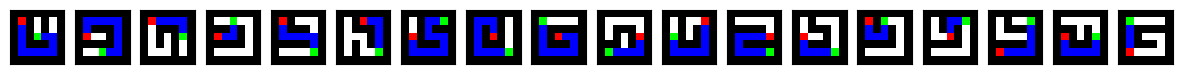

In [11]:
plot_dataset_mazes(dataset_filtered_from_scratch)
plot_dataset_mazes(dataset_filtered_from_scratch.filter_by.path_length(min_length=3))

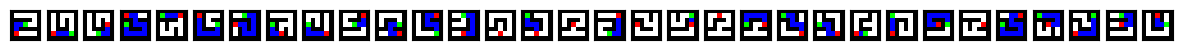

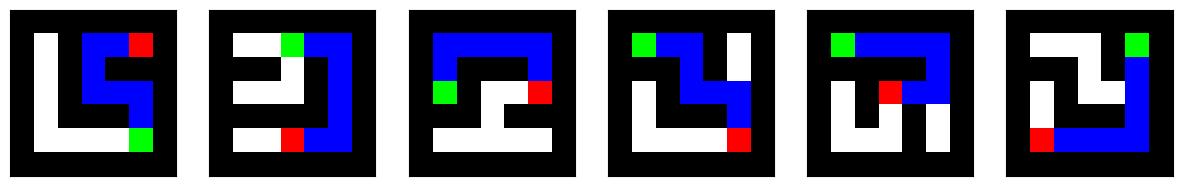

In [12]:
dataset_filtered_custom: MazeDataset = dataset.custom_maze_filter(
	lambda m, p: len(m.solution) == p,
	p=5,
)
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered_custom)